## Mental simulation test in Experiment 1

In [1]:
import glob
import pickle

raw_data = []

for path in glob.glob('../../data/kinematics/kuka_fwd_mental_sim_30k/raw_data/*.pkl'):
    with open(path, 'rb') as f:
        raw_data.append(pickle.load(f))

In [2]:
data = raw_data[0]

for part in raw_data[1:]:
    for n_steps in part:
        data[n_steps].extend(part[n_steps])

In [3]:
with open('../../data/kinematics/kuka_fwd_mental_sim_30k/kuka_fwd_mental_sim_30k.pkl', 'wb') as f:
    pickle.dump(data, f)

In [11]:
with open('../../data/kinematics/kuka_fwd_mental_sim_30k/kuka_fwd_mental_sim_30k.pkl', 'rb') as f:
    data = pickle.load(f)

In [ ]:
from tensorflow.keras.saving import load_model
from tensorflow.keras.models import Model

fwd_model: Model = load_model('../../models/kinematics/kuka_fwd.keras')

In [11]:
import numpy as np

n_joints = 7
actions = {}

for n_steps in range(1, 11):
    actions[n_steps] = []

    for series in data[n_steps]:
        a_series = []

        s0 = series[0]
        joints_0, eff_0 = s0[:n_joints], s0[n_joints:]

        for s1 in series[1:]:
            joints_1, eff_1 = s1[:n_joints], s1[n_joints:]
            a = joints_1 - joints_0

            a_series.append(a)

            s0 = s1
            joints_0, eff_0 = joints_1, eff_1

        actions[n_steps].append(a_series)

In [ ]:
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

joint_errors = {}
eff_errors = {}

for n_steps in range(1, 11):
    joint_errors[n_steps] = []
    eff_errors[n_steps] = []

    for series, a_series in tqdm(
            zip(data[n_steps], actions[n_steps]),
            desc=f'n_steps = {n_steps}',
            total=len(data[n_steps])
    ):
        s0_true = series[0]
        s0_pred = s0_true

        for a in a_series:
            x = np.expand_dims(np.hstack((s0_pred, a)), axis=0)
            y_pred = fwd_model.predict(x, verbose=0)

            joints_1_pred = y_pred[0][0]
            eff_1_pred = y_pred[1][0]
            s1_pred = np.hstack((joints_1_pred, eff_1_pred))

            s0_pred = s1_pred

        s1_true = series[-1]
        joints_1_true, eff_1_true = s1_true[:n_joints], s1_true[n_joints:]

        joint_errors[n_steps].append(mean_absolute_error(joints_1_true, joints_1_pred))
        eff_errors[n_steps].append(mean_absolute_error(eff_1_true, eff_1_pred))

In [ ]:
import pickle

with open('./errors.pkl', 'wb') as f:
    pickle.dump((joint_errors, eff_errors), f)

In [14]:
import pickle

with open('../../data/kinematics/kuka_fwd_mental_sim_30k/errors_6k.pkl', 'rb') as f:
    joint_errors, eff_errors = pickle.load(f)

In [16]:
import numpy as np

x = list(range(1, 11))

j_means = [0] + [np.mean(joint_errors[n]) for n in x]
e_means = [0] + [np.mean(eff_errors[n]) for n in x]

j_bounds = [0] + [np.std(joint_errors[n]) for n in x]
e_bounds = [0] + [np.std(eff_errors[n]) for n in x]

x = [0] + x

<Figure size 640x480 with 0 Axes>

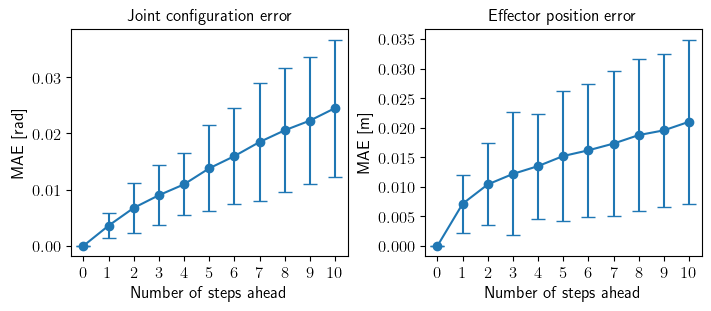

In [17]:
import matplotlib.pyplot as plt

plt.clf()
rc = {
    'font.family': 'serif',
    'text.usetex': True,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'svg.fonttype': 'none'
}

with plt.rc_context(rc):
    fig, (ax0, ax1) = plt.subplots(ncols=2, layout='constrained', figsize=(7, 3))
    
    ax0.errorbar(
        x, j_means,
        yerr=j_bounds,
        fmt='-o',
        capsize=5
    )
    ax0.set_title('Joint configuration error', fontsize=12)
    ax0.set_xticks(x)
    ax0.set_xlabel('Number of steps ahead', fontsize=12)
    ax0.set_ylabel('MAE [rad]', fontsize=12)
    
    ax1.errorbar(
        x, e_means,
        yerr=e_bounds,
        fmt='-o',
        capsize=5
    )
    ax1.set_title('Effector position error', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xlabel('Number of steps ahead', fontsize=12)
    ax1.set_ylabel('MAE [m]', fontsize=12)
    
    plt.savefig('../../plots/kuka/kinematics/kuka_mental_sim_err_step0.svg', format='svg')
    
    # plt.show()